#### Chapter 8: Market-Based Valuation


#### 8.2 Market Model
* Given a model of an asset's return behavior model, price options based on this model
* Use Merton's jump diffusion model to model such behavior
* Continuous market model
* $dS_t = (r - r_j)S_tdt + \sigma S_tdZ_t +  J_tS_tN_t$
* $S_t$: Index level at time t
* $r$:  constant risk-less short rate
* $r_j$: drift correction for jump
* $\sigma$: constant volatlity of $S$
* $Z_t$: Standard Brownian motion
* $J_t$: Jump at time t
* $N_t$: Poisson process with intensity $\lambda$

#### FFT and Integration approach
* This system can be solved via numerical integration
* Given this integration approach, there is a Fast Fourier Transform that you can apply to solve the system

#### Calibration
* The process of calibration is find parameters for our model such that error between the model and observed values is minimized 
* We use RMSE as our cost function to minimize
* We are minimizing across all prices as to improve our model
* The implementation here is first through brute force perform global minimization
* Then give a set of parameters, perfom a local minimization 
* There is a rough scan at the global level and then if some thresholds are hit, scan locally for minimums

#### Simulation
* Perform Monte Carlo on discretized models 
* Optimal parameters from the calibration step are used for the simulation
* Comparing the Integration, FFT and MCS approaches yields close but inexact estimates of option value

#### Conclusions
* Using a jump-diffusion model, we valued our options using Integration and FFT techniques
* Adding market prices for the options allowed us to calibrate and improve pricing accuracy
* Using a Monte Carlo pricing approach and by discretizing the continuous models we are able to value our options through simulation
* Comparing the different methods yielded close but different valuations 


In [1]:
from pylab import plt
plt.style.use('seaborn')
%matplotlib inline

#### Valuation by Integration

In [6]:
# Valuation of European Call Options
# in Merton's (1976) Jump Diffusion Model
# via Numerical Integration
# 08_m76/M76_valuation_INT.py
#
# (c) Dr. Yves J. Hilpisch
# Derivatives Analytics with Python

#
# Model Parameters
#
S0 = 100.0  # initial index level
K = 100.0  # strike level
T = 1.0  # call option maturity
r = 0.05  # constant short rate
sigma = 0.4  # constant volatility of diffusion
lamb = 1.0  # ump frequency p.a.
mu = -0.2  # expected jump size
delta = 0.1  # jump size volatility

#
# Valuation by Integration
#


def M76_value_call_INT(S0, K, T, r, sigma, lamb, mu, delta):
    ''' Valuation of European call option in M76 model via
    Lewis (2001) Fourier-based approach.

    Parameters
    ==========
    S0: float
        initial stock/index level
    K: float
        strike price
    T: float
        time-to-maturity (for t=0)
    r: float
        constant risk-free short rate
    sigma: float
        volatility factor in diffusion term
    lamb: float
        jump intensity
    mu: float
        expected jump size
    delta: float
        standard deviation of jump

    Returns
    =======
    call_value: float
        European call option present value
    '''
    int_value = quad(lambda u: M76_integration_function(u, S0, K, T, r,
                     sigma, lamb, mu, delta), 0, 50, limit=250)[0]
    call_value = S0 - np.exp(-r * T) * math.sqrt(S0 * K) / math.pi * int_value
    return call_value


def M76_integration_function(u, S0, K, T, r, sigma, lamb, mu, delta):
    ''' Valuation of European call option in M76 model via
    Lewis (2001) Fourier-based approach: integration function.

    Parameter definitions see function M76_value_call_INT. '''
    JDCF = M76_characteristic_function(u - 0.5 * 1j, T, r,
                                       sigma, lamb, mu, delta)
    value = 1 / (u ** 2 + 0.25) * (np.exp(1j * u * math.log(S0 / K)) *
                                   JDCF).real
    return value


def M76_characteristic_function(u, T, r, sigma, lamb, mu, delta):
    ''' Valuation of European call option in M76 model via
    Lewis (2001) Fourier-based approach: characteristic function.

    Parameter definitions see function M76_value_call_INT. '''
    omega = r - 0.5 * sigma ** 2 - lamb * (np.exp(mu + 0.5 * delta ** 2) - 1)
    value = np.exp((1j * u * omega - 0.5 * u ** 2 * sigma ** 2 +
            lamb * (np.exp(1j * u * mu - u ** 2 * delta ** 2 * 0.5) - 1)) * T)
    return value


print("Value of Call Option %8.3f"
          % M76_value_call_INT(S0, K, T, r, sigma, lamb, mu, delta))

Value of Call Option   19.948


In [7]:
#%run 08_m76/M76_valuation_INT.py

#### Valuation by FFT

In [10]:
#
# Valuation of European Call Options
# in Merton's (1976) Jump Diffusion Model
# via Fast Fourier Transform (FFT)
# 08_m76/M76_valuation_FFT.py
#
# (c) Dr. Yves J. Hilpisch
# Derivatives Analytics with Python
#
import math
import numpy as np
from numpy.fft import *

#
# Model Parameters
#
S0 = 100.0  # initial index level
K = 100.0  # strike level
T = 1.0  # call option maturity
r = 0.05  # constant short rate
sigma = 0.4  # constant volatility of diffusion
lamb = 1.0  # jump frequency p.a.
mu = -0.2  # expected jump size
delta = 0.1  # jump size volatility


#
# Valuation by FFT
#


def M76_value_call_FFT(S0, K, T, r, sigma, lamb, mu, delta):
    ''' Valuation of European call option in M76 model via
    Carr-Madan (1999) Fourier-based approach.

    Parameters
    ==========
    S0: float
        initial stock/index level
    K: float
        strike price
    T: float
        time-to-maturity (for t=0)
    r: float
        constant risk-free short rate
    sigma: float
        volatility factor in diffusion term
    lamb: float
        jump intensity
    mu: float
        expected jump size
    delta: float
        standard deviation of jump

    Returns
    =======
    call_value: float
        European call option present value
    '''
    k = math.log(K / S0)
    x0 = math.log(S0 / S0)
    g = 2  # factor to increase accuracy
    N = g * 4096
    eps = (g * 150.) ** -1
    eta = 2 * math.pi / (N * eps)
    b = 0.5 * N * eps - k
    u = np.arange(1, N + 1, 1)
    vo = eta * (u - 1)
    # Modificatons to Ensure Integrability
    if S0 >= 0.95 * K:  # ITM case
        alpha = 1.5
        v = vo - (alpha + 1) * 1j
        mod_char_fun = math.exp(-r * T) * M76_characteristic_function(
            v, x0, T, r, sigma, lamb, mu, delta) \
            / (alpha ** 2 + alpha - vo ** 2 + 1j * (2 * alpha + 1) * vo)
    else:  # OTM case
        alpha = 1.1
        v = (vo - 1j * alpha) - 1j
        mod_char_fun_1 = math.exp(-r * T) * (1 / (1 + 1j * (vo - 1j * alpha))
                                             - math.exp(r * T) /
                                             (1j * (vo - 1j * alpha))
                                             - M76_characteristic_function(
                    v, x0, T, r, sigma, lamb, mu, delta) /
                    ((vo - 1j * alpha) ** 2 - 1j * (vo - 1j * alpha)))
        v = (vo + 1j * alpha) - 1j
        mod_char_fun_2 = math.exp(-r * T) * (1 / (1 + 1j * (vo + 1j * alpha))
                                             - math.exp(r * T) /
                                             (1j * (vo + 1j * alpha))
                                             - M76_characteristic_function(
                    v, x0, T, r, sigma, lamb, mu, delta) /
                    ((vo + 1j * alpha) ** 2 - 1j * (vo + 1j * alpha)))

    # Numerical FFT Routine
    delt = np.zeros(N, dtype=np.float)
    delt[0] = 1
    j = np.arange(1, N + 1, 1)
    SimpsonW = (3 + (-1) ** j - delt) / 3
    if S0 >= 0.95 * K:
        fft_func = np.exp(1j * b * vo) * mod_char_fun * eta * SimpsonW
        payoff = (fft(fft_func)).real
        call_value_m = np.exp(-alpha * k) / math.pi * payoff
    else:
        fft_func = (np.exp(1j * b * vo) *
                    (mod_char_fun_1 - mod_char_fun_2) *
                    0.5 * eta * SimpsonW)
        payoff = (fft(fft_func)).real
        call_value_m = payoff / (np.sinh(alpha * k) * math.pi)
    pos = int((k + b) / eps)
    call_value = call_value_m[pos]
    return call_value * S0



print("Value of Call Option %8.3f"
        % M76_value_call_FFT(S0, K, T, r, sigma, lamb, mu, delta))

Value of Call Option   19.948


In [11]:
#%run 08_m76/M76_valuation_FFT.py

In [12]:
#
# Calibration of Merton's (1976)
# Jump Diffusion Model
# via Fast Fourier Transform
# 08_m76/M76_calibration_FFT.py
#
# (c) Dr. Yves J. Hilpisch
# Derivatives Analytics with Python
#
import math
import numpy as np
import pandas as pd
import scipy.optimize as sop
import matplotlib.pyplot as plt
import matplotlib as mpl
from M76_valuation_FFT import M76_value_call_FFT

mpl.rcParams['font.family'] = 'serif'
np.set_printoptions(suppress=True,
                    formatter={'all': lambda x: '%5.3f' % x})
#
# Market Data from www.eurexchange.com
# as of 30. September 2014
#
h5 = pd.HDFStore('08_m76/option_data.h5', 'r')
data = h5['data']  # European call & put option data (3 maturities)
h5.close()
S0 = 3225.93  # EURO STOXX 50 level
r = 0.0005  # ECB base rate

# Option Selection
tol = 0.02
options = data[(np.abs(data['Strike'] - S0) / S0) < tol].copy()
options['Date'] = pd.DatetimeIndex(options['Date'])
options['Maturity'] = pd.DatetimeIndex(options['Maturity'])

#
# Error Function
#


def M76_error_function_FFT(p0):
    ''' Error Function for parameter calibration in M76 Model via
    Carr-Madan (1999) FFT approach.

    Parameters
    ==========
    sigma: float
        volatility factor in diffusion term
    lamb: float
        jump intensity
    mu: float
        expected jump size
    delta: float
        standard deviation of jump

    Returns
    =======
    RMSE: float
        root mean squared error
    '''
    global i, min_RMSE
    sigma, lamb, mu, delta = p0
    if sigma < 0.0 or delta < 0.0 or lamb < 0.0:
        return 500.0
    se = []
    for row, option in options.iterrows():
        T = (option['Maturity'] - option['Date']).days / 365.
        model_value = M76_value_call_FFT(S0, option['Strike'], T,
                                         r, sigma, lamb, mu, delta)
        se.append((model_value - option['Call']) ** 2)
    RMSE = math.sqrt(sum(se) / len(se))
    min_RMSE = min(min_RMSE, RMSE)
    if i % 50 == 0:
        print('%4d |' % i, np.array(p0), '| %7.3f | %7.3f' % (RMSE, min_RMSE))
    i += 1
    return RMSE


def generate_plot(opt, options):
    #
    # Calculating Model Prices
    #
    sigma, lamb, mu, delta = opt
    options['Model'] = 0.0
    for row, option in options.iterrows():
        T = (option['Maturity'] - option['Date']).days / 365.
        options.loc[row, 'Model'] = M76_value_call_FFT(S0, option['Strike'],
                                            T, r, sigma, lamb, mu, delta)

    #
    # Plotting
    #
    mats = sorted(set(options['Maturity']))
    options = options.set_index('Strike')
    for i, mat in enumerate(mats):
        options[options['Maturity'] == mat][['Call', 'Model']].\
            plot(style=['b-', 'ro'], title='%s' % str(mat)[:10],
                 grid=True)
        plt.ylabel('option value')
        plt.savefig('../images/08_m76/M76_calibration_3_%s.pdf' % i)


if __name__ == '__main__':
    #
    # Calibration
    #
    i = 0  # counter initialization
    min_RMSE = 100  # minimal RMSE initialization
    p0 = sop.brute(M76_error_function_FFT,
                   ((0.075, 0.201, 0.025),
                    (0.10, 0.401, 0.1), (-0.5, 0.01, 0.1),
                    (0.10, 0.301, 0.1)), finish=None)

    # p0 = [0.15, 0.2, -0.3, 0.2]
    opt = sop.fmin(M76_error_function_FFT, p0,
                   maxiter=500, maxfun=750,
                   xtol=0.000001, ftol=0.000001)


   0 | [0.075 0.100 -0.500 0.100] |  35.009 |  35.009
  50 | [0.075 0.300 -0.100 0.200] |  34.892 |  12.884
 100 | [0.100 0.200 -0.200 0.100] |  24.976 |   9.283
 150 | [0.125 0.100 -0.400 0.300] |   9.822 |   7.415
 200 | [0.125 0.400 -0.500 0.200] |  53.397 |   5.581
 250 | [0.150 0.200 0.000 0.100] |   5.022 |   3.822
 300 | [0.175 0.100 -0.200 0.300] |  18.181 |   3.822
 350 | [0.175 0.400 -0.300 0.200] |  46.957 |   3.822
 400 | [0.200 0.300 -0.400 0.100] |  61.238 |   3.822
 450 | [0.150 0.095 -0.206 0.198] |   3.798 |   3.798
 500 | [0.160 0.008 -0.282 0.097] |   3.585 |   3.584
 550 | [0.160 0.004 -0.273 0.113] |   3.584 |   3.584
 600 | [0.160 0.005 -0.271 0.118] |   3.584 |   3.584
 650 | [0.160 0.004 -0.286 0.118] |   3.584 |   3.584
 700 | [0.160 0.003 -0.446 0.121] |   3.584 |   3.584
 750 | [0.160 0.002 -0.611 0.112] |   3.583 |   3.583
 800 | [0.160 0.001 -1.035 0.143] |   3.583 |   3.583
 850 | [0.160 0.001 -1.469 0.193] |   3.583 |   3.583
 900 | [0.160 0.001 -2.480 0.

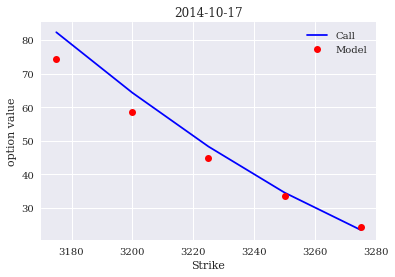

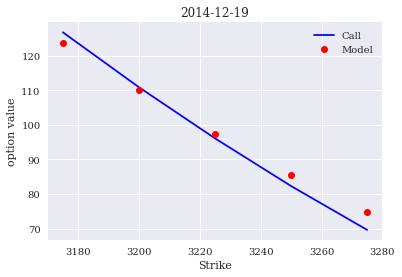

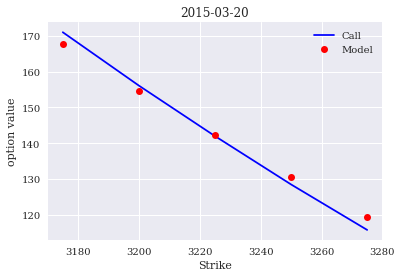

In [13]:
generate_plot(opt, options);

In [15]:
#
# Calibration of Merton's (1976)
# Jump Diffusion Model
# to Short Maturity Data
# 08_m76/M76_calibration_single.py
#
# (c) Dr. Yves J. Hilpisch
# Derivatives Analytics with Python
#
import math
import numpy as np
import pandas as pd
import scipy.optimize as sop
import matplotlib.pyplot as plt
import matplotlib as mpl
from M76_valuation_FFT import M76_value_call_FFT

mpl.rcParams['font.family'] = 'serif'
np.set_printoptions(suppress=True,
                    formatter={'all': lambda x: '%5.3f' % x})

#
# Market Data from www.eurexchange.com
# as of 30. September 2014
#
h5 = pd.HDFStore('08_m76/option_data.h5', 'r')
data = h5['data']  # European call & put option data (3 maturities)
h5.close()
S0 = 3225.93  # EURO STOXX 50 level
r = 0.005  # assumption

# Option Selection
tol = 0.05
options = data[(np.abs(data['Strike'] - S0) / S0) < tol]
mats = sorted(set(options['Maturity']))
options = options[options['Maturity'] == mats[0]]
options['Date'] = pd.DatetimeIndex(options['Date'])
options['Maturity'] = pd.DatetimeIndex(options['Maturity'])

#
# Error Function
#


def M76_error_function_FFT(p0):
    ''' Error function for parameter calibration in M76 Model via
    Carr-Madan (1999) FFT approach.

    Parameters
    ==========
    sigma: float
        volatility factor in diffusion term
    lamb: float
        jump intensity
    mu: float
        expected jump size
    delta: float
        standard deviation of jump

    Returns
    =======
    RMSE: float
        root mean squared error
    '''
    global i, min_RMSE
    sigma, lamb, mu, delta = p0
    if sigma < 0.0 or delta < 0.0 or lamb < 0.0:
        return 500.0
    se = []
    for row, option in options.iterrows():
        T = (option['Maturity'] - option['Date']).days / 365.
        model_value = M76_value_call_FFT(S0, option['Strike'], T,
                                         r, sigma, lamb, mu, delta)
        se.append((model_value - option['Call']) ** 2)
    RMSE = math.sqrt(sum(se) / len(se))
    min_RMSE = min(min_RMSE, RMSE)
    if i % 50 == 0:
        print('%4d |' % i, np.array(p0), '| %7.3f | %7.3f' % (RMSE, min_RMSE))
    i += 1
    return RMSE


#
# Graphical Output
#
def generate_plot(opt, options):
    #
    # Calculating Model Prices
    #
    sigma, lamb, mu, delta = opt
    options['Model'] = 0.0
    for row, option in options.iterrows():
        T = (option['Maturity'] - option['Date']).days / 365.
        options.loc[row, 'Model'] = M76_value_call_FFT(S0, option['Strike'],
                                    T, r, sigma, lamb, mu, delta)

    #
    # Plotting
    #
    options = options.set_index('Strike')
    fig, ax = plt.subplots(2, sharex=True, figsize=(8, 7))
    options[['Call', 'Model']].plot(style=['b-', 'ro'],
                    title='%s' % str(option['Maturity'])[:10], ax=ax[0])
    ax[0].set_ylabel('option values')
    ax[0].grid(True)
    xv = options.index.values
    ax[1] = plt.bar(xv - 5 / 2., options['Model'] - options['Call'],
                    width=5)
    plt.ylabel('difference')
    plt.xlim(min(xv) - 10, max(xv) + 10)
    plt.tight_layout()
    plt.grid(True)


#
# Calibration
#
if __name__ == '__main__':
    i = 0
    min_RMSE = 100.
    p0 = sop.brute(M76_error_function_FFT, ((0.10, 0.201, 0.025),
                    (0.1, 0.8, 0.1), (-0.4, 0.01, 0.1),
                    (0.00, 0.121, 0.02)), finish=None)

    opt = sop.fmin(M76_error_function_FFT, p0, xtol=0.00001,
                    ftol=0.00001, maxiter=750, maxfun=1500)


   0 | [0.100 0.100 -0.400 0.000] |  13.102 |  13.102
  50 | [0.100 0.200 -0.200 0.000] |  13.074 |  10.498
 100 | [0.100 0.300 0.000 0.020] |  15.648 |   7.988
 150 | [0.100 0.500 -0.300 0.040] |   6.087 |   4.338
 200 | [0.100 0.600 -0.100 0.060] |  12.132 |   4.338
 250 | [0.125 0.100 -0.400 0.080] |   9.119 |   4.014
 300 | [0.125 0.200 -0.200 0.100] |   9.139 |   4.014
 350 | [0.125 0.300 0.000 0.120] |  10.455 |   3.779
 400 | [0.125 0.500 -0.200 0.000] |   5.123 |   1.560
 450 | [0.125 0.600 0.000 0.020] |  11.610 |   1.352
 500 | [0.150 0.100 -0.300 0.040] |   6.047 |   1.352
 550 | [0.150 0.200 -0.100 0.060] |   6.874 |   1.352
 600 | [0.150 0.400 -0.400 0.080] |   3.860 |   1.352
 650 | [0.150 0.500 -0.200 0.100] |   2.776 |   1.352
 700 | [0.150 0.600 0.000 0.120] |   6.279 |   1.352
 750 | [0.175 0.100 -0.200 0.000] |   5.391 |   1.352
 800 | [0.175 0.200 0.000 0.020] |   5.842 |   1.352
 850 | [0.175 0.400 -0.300 0.040] |   7.156 |   1.352
 900 | [0.175 0.500 -0.100 0.060]

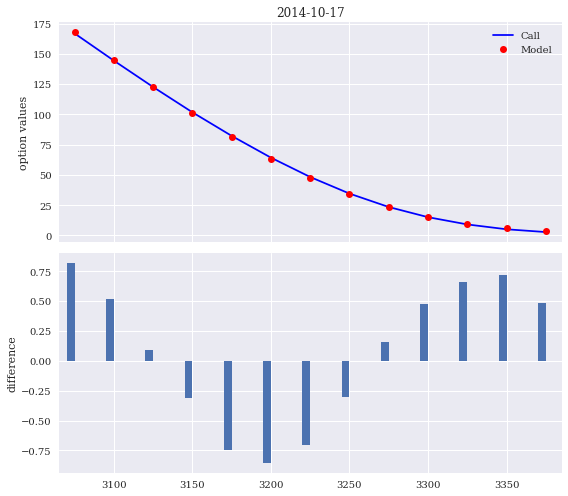

In [16]:
generate_plot(opt, options)


In [25]:
#
# Valuation of European Call Options
# in Merton's (1976) Jump Diffusion Model
# via Monte Carlo Simulation
# 08_m76/M76_valuation_MCS.py
#
# (c) Dr. Yves J. Hilpisch
# Derivatives Analytics with Python
#
import math
import numpy as np
import pandas as pd

#
# Model Parameters (from Calibration)
#
S0 = 3225.93  # EURO STOXX 50 level (30.09.2014)
T = 0.22  # shortest maturity
r = 0.005  # assumption

# from calibration
sigma, lamb, mu, delta = [0.124, 1.393, -0.137, 0.000]

#
# Valuation by Simulation
#
seed = 100000  # seed value
M = 50  # time steps
I = 200000  # paths
disc = 2  # 1 = simple Euler; else = log Euler


def M76_generate_paths(S0, T, r, sigma, lamb, mu, delta, M, I):
    ''' Generate Monte Carlo Paths for M76 Model.
    Parameters
    ==========
    S0: float
        initial stock/index level
    K: float
        strike price
    T: float
        time-to-maturity (for t=0)
    r: float
        constant risk-free short rate
    sigma: float
        volatility factor in diffusion term
    lamb: float
        jump intensity
    mu: float
        expected jump size
    delta: float
        standard deviation of jump
    M: int
        number of time intervals
    I: int
        number of paths

    Returns
    =======
    S: array
        simulated paths
    '''
    dt = T / M
    rj = lamb * (math.exp(mu + 0.5 * delta ** 2) - 1)
    shape = (M + 1, I)
    S = np.zeros((M + 1, I), dtype=np.float)
    S[0] = S0

    np.random.seed(10000)
    rand1 = np.random.standard_normal(shape)
    rand2 = np.random.standard_normal(shape)
    rand3 = np.random.poisson(lamb * dt, shape)

    for t in range(1, M + 1, 1):
        if disc == 1:
            S[t] = S[t - 1] * ((1 + (r - rj) * dt) + sigma *
                               math.sqrt(dt) * rand1[t] +
                               (np.exp(mu + delta * rand2[t]) - 1) *
                               rand3[t])
        else:
            S[t] = S[t - 1] * (np.exp((r - rj - 0.5 * sigma ** 2) * dt +
                                      sigma * math.sqrt(dt) * rand1[t]) +
                               (np.exp(mu + delta * rand2[t]) - 1) *
                               rand3[t])
    return S


def M76_value_call_MCS(K):
    ''' Function to calculate the MCS estimator given K.

    Parameters
    ==========
    K: float
        strike price

    Returns
    =======
    call_mcs: float
        European call option Monte Carlo estimator
    '''
    return math.exp(-r * T) * np.sum(np.maximum(S[-1] - K, 0)) / I


if __name__ == '__main__':

    # Single Valuation
    S = M76_generate_paths(S0, T, r, sigma, lamb, mu, delta, M, I)
    print("Value of Call Option %8.3f" % M76_value_call_MCS(S0))

    # Value Comparisons
    strikes = np.arange(3000, 3601, 50)
    values = np.zeros((3, len(strikes)), dtype=np.float)
    z = 0
    for k in strikes:
        print("CALL STRIKE       %10.3f" % k)
        print("----------------------------")


        values[1, z] = M76_value_call_FFT(S0, k, T, r, sigma,
                                          lamb, mu, delta)
        
#         values[0, z] = M76_value_call_INT(S0, k, T, r, sigma,
#                                           lamb, mu, delta)
#         print("Call Value by Int %10.3f" % values[0, z])
        print("Call Value by FFT %10.3f" % values[1, z])
#         print("Difference FFT/Int%10.3f" % (values[1, z] - values[0, z]))
        values[2, z] = M76_value_call_MCS(k)
        print("Call Value by MCS %10.3f" % values[2, z])
        print("Difference MCS/FFT%10.3f" % (values[2, z] - values[1, z]))
        print("----------------------------")
        z = z + 1

    results = pd.DataFrame(values.T, index=strikes, columns=[
        'INT', 'FFT', 'MCS'])
    results.index.name = 'Strike'


Value of Call Option  119.360
CALL STRIKE         3000.000
----------------------------
Call Value by FFT    273.856
Call Value by MCS    274.741
Difference MCS/FFT     0.885
----------------------------
CALL STRIKE         3050.000
----------------------------
Call Value by FFT    235.366
Call Value by MCS    236.215
Difference MCS/FFT     0.849
----------------------------
CALL STRIKE         3100.000
----------------------------
Call Value by FFT    198.955
Call Value by MCS    199.739
Difference MCS/FFT     0.784
----------------------------
CALL STRIKE         3150.000
----------------------------
Call Value by FFT    164.940
Call Value by MCS    165.654
Difference MCS/FFT     0.714
----------------------------
CALL STRIKE         3200.000
----------------------------
Call Value by FFT    133.715
Call Value by MCS    134.354
Difference MCS/FFT     0.638
----------------------------
CALL STRIKE         3250.000
----------------------------
Call Value by FFT    105.702
Call Value by

In [28]:
#%run 08_m76/M76_valuation_MCS.py

Text(0,0.5,'option value')

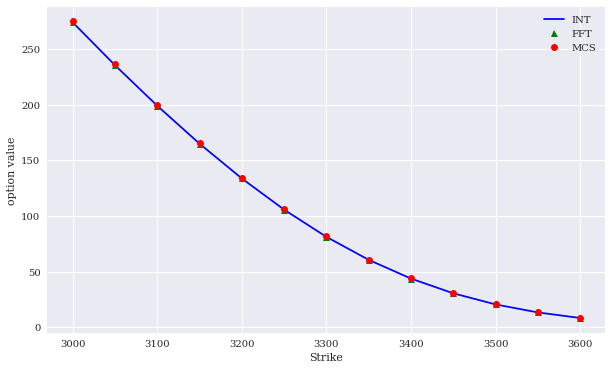

In [27]:
results.plot(style=['b-', 'g^', 'ro'], figsize=(10, 6))
plt.ylabel('option value')

In [ ]:
8.2 Market Model